# Enhanced Custom Model
As seen in previous notebook (Basic Custom Model). Our model is not enough good to descrive our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from autograd import grad
import autograd.numpy as anp
from statsmodels.tsa.seasonal import seasonal_decompose

rand = np.random.RandomState(13)

The idea is to use additional variables from our data to try to explain the results but keeping the same model type and loss function. In this case we follow the equation:

\begin{equation}
D = e^{ w_0 -\beta \log{\tilde{P}} }
\label{eqn:demeq}
\end{equation}
with:
\begin{equation}
\tilde{P} = w_4 x_3 + w_5 x_4 + w_6 P
\end{equation}
\begin{equation}
\beta = w_1 x_1 + w_2 x_2 + w_3 x_3 
\end{equation}

The idea is to guide our model through a loss that penalises the parameters that lead the demand to increase if the price increases and the other way around. We are trying to create a more general model less prone to overfit and achieve a better representation of the unseen data from 2019. For that we take the variables P, $\tilde{P}$ and D, $\hat{D}$ and, considering the real data as a starting point, we define the price and demand delta as: 
\begin{equation}
\Delta P_j = P_j - \tilde{P}_j
\end{equation}
\begin{equation}
\Delta D_j = D_j - \hat{D}_j
\end{equation}

Then, we incorporate this knowledge in our loss function as follows:


if $\Delta P > 0$ and $\Delta D > 0$:

\begin{equation}
f_2(w) = 2 f_1(w) + \sqrt{\sum_{j=1}^{n}|(\tilde{P}_j-P_j)+(\hat{D}_j-D_j)|^2 }
\label{eqn:Einstein}
\end{equation}


if $\Delta P < 0$ and $\Delta D < 0$:

\begin{equation}
f_2(w) = 2 f_1(w) + \sqrt{\sum_{j=1}^{n}|(P_j - \tilde{P}_j)+(D_j - \hat{D}_j)|^2 }
\end{equation}

\noindent where $f_2(w)$ is our new loss function and $f_1(w)$ the original loss function from the basic model.

The structure of this Notebook is the same as for Basic Custom Model notebook.


In [74]:
#We define the original loss
def my_autograd_loss(d,X,w,model):
    n_var = X.shape[1] 
    p_hat = pnew(X,w)
    d_hat = model(X,w)
    
    fit = (d-d_hat)
    # fitp = (X[:,0]-p_hat) for tests with the p
       
    fit_norm = anp.linalg.norm(fit)
    #fitp_norm = anp.linalg.norm(fitp) for tests with the p
    
    return fit_norm 

#We define the new loss
def my_autograd_loss2(d,X,w,model):
    n_var = X.shape[1] 
    n = X.shape[0]
    p_hat = pnew(X,w)
    d_hat = model(X,w)
    bad_dec = 0
    bad_inc = 0
    for i in range(n):
        if (X[i,0]<p_hat[i]) and (d_hat[i]>d[i]):
            bad_dec += (p_hat[i]-X[i,0])+(d_hat[i]-d[i])
        else:
            bad_dec += 0.

        if (X[i,0]>p_hat[i]) and (d_hat[i]<d[i]):
            bad_inc += (X[i,0]-p_hat[i])+(d[i]-d_hat[i])
        else:
            bad_inc += 0.

    fit = (d-d_hat)
    fitp = (X[:,0]-p_hat)
    
    #bad_inc_norm = anp.linalg.norm(bad_inc)
    #bad_dec_norm = anp.linalg.norm(bad_dec)
    fit_norm = anp.linalg.norm(fit)
    fitp_norm = anp.linalg.norm(fitp)
    
    return 2*fit_norm + bad_inc + bad_dec #+ fitp_norm
    #return fit_norm + fitp_norm + bad_dec_norm
#Autograd gradient
my_training_gradient = grad(my_autograd_loss,2)
my_training_gradient2 = grad(my_autograd_loss2,2)

#Model for creating the synthetic data
def model1_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(w[0]-w[1]*(anp.log(X[:,0]))+w[2]*noise)
    return y

#Different models applied
def pnew(X,w):
    p = w[1]*X[:,1] + w[2]*X[:,2] + w[3]*X[:,3] + w[4]*X[:,0]
    return p

def model6_data(X,w,noise_p):
    p_new = pnew(X,w)
    noise = anp.random.normal(0,noise_p,X.shape[0])
    y = anp.exp(w[0] - w[5]*(anp.log(p_new)) + w[6]*noise)
    return y

def model6(X,w):
    p_new = pnew(X,w)
    y = anp.exp(w[0] - w[5]*(anp.log(p_new)))
    return y



def pnew2(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,4] + w[6]*X[:,0]
    return p

def pnew3(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,1] + w[6]*X[:,0] + w[4]*X[:,2]
    return p

def pnew4(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,1] + w[6]*X[:,0] + w[4]*X[:,2] + w[7]*X[:,4]
    return p

def model6b_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)) + noise)
    return y

def model6b(X,w):
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

def model7(X,w):
    p_new = pnew3(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y


def model6b_data(X,w,noise_p):
    noise = anp.random.normal(0,noise_p,X.shape[0])
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)) + w[6]*noise)
    return y

def model8(X,w):
    p_new = pnew4(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

def pnew4(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,1] + w[6]*X[:,0] + w[4]*X[:,2] + w[7]*X[:,4]
    return p

### Synthetic data verification
We now create synthetic data with some noise on it.

In [80]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)

#dataframe
dades = {'p':p,'q':q,'r':r,'s':s}
sim1 = pd.DataFrame(data=dades)
gen_params = [5.5,0.1,0.8,0.5,1.2,1.1,0.1]
sim1['d'] = model6_data(sim1.values,gen_params,0.)
print(sim1.shape)
sim1.head(5)

(50, 5)


p         q         r         s           d
0  31.883777  0.438101  0.023831  0.375041  171.232076
1  31.050238  0.246758  0.013674  0.019445  171.794812
2  28.984500  0.864834  0.016962  0.213317  172.688461
3  42.916849  0.975737  0.015924  0.482980  166.115764
4  44.562058  0.282193  0.023007  0.626146  165.677633

Let's check if the model cxan learn the weights of the synthetic data:

nit 0  w:  [1.00005549 0.9998051  0.99959026 0.99998315 0.99962529 0.97721488] grad [-5.54884192e-01  1.94900956e+00  4.09735395e+00  1.68465938e-01
  3.74708037e+00  2.27851214e+02] loss 1204.0240583231077 time 0.005000114440917969
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
eta 9.688901040699995e-07
eta 6.782230728489996e-07
eta 4.747561509942997e-07
eta 3.3232930569600976e-07
eta 2.326305139872068e-07
eta 1.6284135979104476e-07
eta 1.1398895185373132e-07
eta 7.979226629761192e-08
eta 5.5854586408328346e-08
nit 100000  w:  [5.49485859 0.10153683 0.78240154 0.99827092 0.75175783 0.97956945] grad [ 0.0430162   0.01170622  2.01058859  0.04375272  3.26189628 -0.06624327] loss 3.739561414285861 time 260.5353901386261
nit 200000  w:  [5

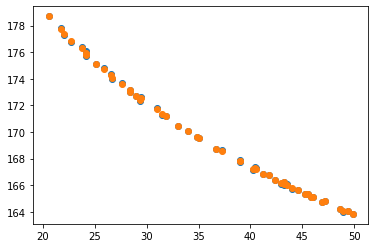

In [85]:
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(6)
w_o =np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model6

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

let's try with more noise

In [86]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)

#dataframe
dades = {'p':p,'q':q,'r':r,'s':s}
sim1 = pd.DataFrame(data=dades)
gen_params = [5.5,0.1,0.8,0.5,0.2,1.1,0.1]
sim1['d'] = model6_data(sim1.values,gen_params,0.1)
print(sim1.shape)
sim1.head(5)

(50, 5)


p         q         r         s           d
0  35.891689  0.546859  0.036714  0.067003  169.037348
1  41.973488  0.781685  0.014043  0.971628  167.657622
2  38.616279  0.730199  0.021170  0.472149  167.520957
3  33.994605  0.455238  0.020469  0.484006  175.364917
4  38.338645  0.738614  0.037826  0.451193  164.797314

nit 0  w:  [1.00056451 0.9980252  0.99568325 0.99983298 0.99612509 0.76226224] grad [-5.64513103e-01  1.97480013e+00  4.31675237e+00  1.67022265e-01
  3.87491010e+00  2.37737759e+02] loss 1256.1679200583542 time 0.002000093460083008
eta 0.0007
eta 0.00049
eta 0.000343
eta 0.00024009999999999998
eta 0.00016806999999999998
eta 0.00011764899999999998
eta 8.235429999999999e-05
eta 5.764800999999999e-05
eta 4.035360699999999e-05
eta 2.8247524899999994e-05
eta 1.9773267429999995e-05
eta 1.3841287200999995e-05
eta 9.688901040699997e-06
eta 6.782230728489997e-06
eta 4.747561509942998e-06
eta 3.323293056960098e-06
eta 2.3263051398720685e-06
eta 1.6284135979104478e-06
eta 1.1398895185373134e-06
nit 100000  w:  [5.47299537 0.095234   0.68068172 0.9973712  0.63427681 0.97974486] grad [ 0.01376597  0.00376586  1.29653347  0.03511157  1.78209458 -0.04521601] loss 14.453179377190791 time 67.69425702095032
nit 200000  w:  [5.47142501 0.09480419 0.52905452 0.99335503 0.43690371 0.98488183] grad [ 0.013

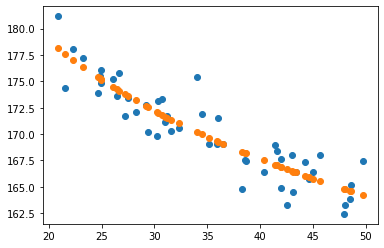

In [87]:
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(6)
w_o =np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.001
nit=0
used_model = model6

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

### More elaborated model

In [105]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)

#dataframe
dades = {'p':p,'q':q,'r':r,'s':s}
sim1 = pd.DataFrame(data=dades)
gen_params = [5.5,0.1,0.8,0.5,0.2,1.1,0.1]
sim1['d'] = model6b_data(sim1.values,gen_params,0.1)
print(sim1.shape)
sim1.head(5)

(50, 5)


p         q         r         s           d
0  42.011523  0.349457  0.011330  0.877593  238.550643
1  35.042640  0.011565  0.034848  0.564671  229.341603
2  46.929200  0.883883  0.032276  0.526850  169.991002
3  38.215671  0.363346  0.015700  0.194743  219.362391
4  44.616343  0.785141  0.021756  0.398214  221.282306

nit 0  w:  [1.0049285  0.99198753 0.99942362 0.99609705 0.76260034] grad [ -4.92850078   8.01247183   0.57638431   3.90295187 237.39966047] loss 1560.8722083220475 time 0.009146451950073242
eta 0.0007
eta 0.00049
eta 0.000343
eta 0.00024009999999999998
eta 0.00016806999999999998
eta 0.00011764899999999998
eta 8.235429999999999e-05
eta 5.764800999999999e-05
eta 4.035360699999999e-05
eta 2.8247524899999994e-05
eta 1.9773267429999995e-05
eta 1.3841287200999995e-05
eta 9.688901040699997e-06
eta 6.782230728489997e-06
eta 4.747561509942998e-06
eta 3.323293056960098e-06
nit 116219
Generative params
[5.5, 0.1, 0.8, 0.5, 0.2, 1.1, 0.1]
Estimated params
[ 5.52290433  0.05982796  0.67066474 -0.00902719  0.99883905]
loss:  170.39640084721324
Real values:
[238.55064284 229.34160332 169.99100238 219.36239109 221.28230559
 187.50391256 189.6123406  253.36633333 220.44081998 190.73920875
 191.51029994 187.02521979 231.82739207 237.98742167 212.24651174
 192.94856197 221.51905264 243.21760139 175.08268

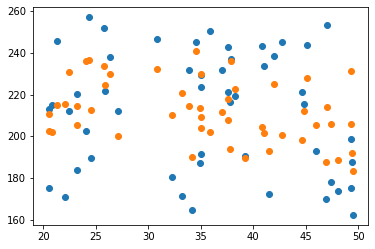

In [106]:
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(5)
w_o =np.ones(5)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.001
nit=0
used_model = model6b

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

looks like the model has not learned the real values, let's try with another initialization and with lower eta.

nit 0  w:  [0.52358649 0.52466654 0.50106117 0.50198797 0.73450126 0.51353017] grad [ -23.58649211  -24.66654213   -1.06117407   -1.98796747 -234.50125853
  -13.5301747 ] loss 1556.5481997272518 time 0.006421327590942383
eta 0.0007
eta 0.00049
eta 0.000343
eta 0.00024009999999999998
eta 0.00016806999999999998
eta 0.00011764899999999998
eta 8.235429999999999e-05
eta 5.764800999999999e-05
eta 4.035360699999999e-05
eta 2.8247524899999994e-05
eta 1.9773267429999995e-05
eta 1.3841287200999995e-05
eta 9.688901040699997e-06
eta 6.782230728489997e-06
eta 4.747561509942998e-06
nit 464500
Generative params
[5.5, 0.1, 0.8, 0.5, 0.2, 1.1, 0.1]
Estimated params
[ 5.3583847  -0.09958349  1.95812104  0.0540033   0.99935413 -0.00635568]
loss:  188.7195563548742
Real values:
[238.55064284 229.34160332 169.99100238 219.36239109 221.28230559
 187.50391256 189.6123406  253.36633333 220.44081998 190.73920875
 191.51029994 187.02521979 231.82739207 237.98742167 212.24651174
 192.94856197 221.51905264 243.21

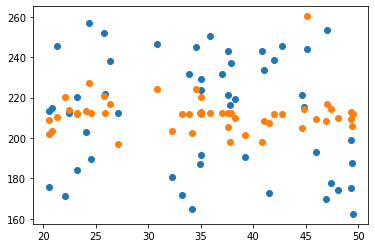

In [112]:
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =0.5*np.ones(6)
w_o =0.5*np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.001
nit=0
used_model = model6b

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

In [10]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)

#dataframe
dades = {'p':p,'q':q,'r':r,'s':s,'t':t}
sim1 = pd.DataFrame(data=dades)
gen_params = [2.5,0.1,0.8,0.5,0.2,1.1,0.]
sim1['d'] = model6b_data(sim1.values,gen_params,0.)
print(sim1.shape)
sim1.head(5)

(50, 6)


p         q         r         s         t          d
0  36.227875  0.766083  0.038000  0.906351  0.265691  28.305880
1  27.647324  0.677649  0.015084  0.726548  0.350531  22.272977
2  26.569500  0.910130  0.014071  0.954483  0.082045  52.815681
3  41.079855  0.863614  0.027832  0.679278  0.615423  15.318211
4  21.828444  0.228113  0.029023  0.471276  0.762225  13.170260

nit 0  w:  [1.0019004  0.99994667 0.99999851 0.99955801 0.97558372 1.00011223] grad [-1.90040145e+01  5.33319315e-01  1.48989364e-02  4.41988589e+00
  2.44162814e+02 -1.12231158e+00] loss 126.05984020145875 time 0.003000020980834961
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
nit 1000000  w:  [ 2.96700843 -0.27240809 -0.23982006 -0.10146299  1.00522904  1.93989185] grad [-6.36167618e-05 -2.30989178e-03  6.48532543e-02 -9.30431774e-04
  1.68319320e-06 -8.29646433e-04] loss 53.66294631668338 time 1313.1033601760864
nit 2000000  w:  [ 2.96803661 -0.23802561 -1.22907942 -0.08809444  1.00522296  1.95372024] grad [-5.88755891e-05 -1.78855589e-03  5.29800276e-02 -6.66431813e-04
 -8.78155369e-07 -8.13353102e-04] loss 53.60442781067362 time 2252.177980184555
nit 3000000  w:  [ 2.96898459 -0.21190471 -2.02649162 -0.07877983  1.00525415  1.96706533] grad [-5.36904949e-05 -1.33465308e-03  4.21374161e-02 -4.51947909e-04
 -2.66

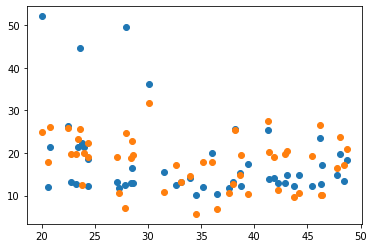

In [171]:
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(6)
w_o =np.ones(6)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model6b

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

In [37]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
z = rand.uniform(0,1,50)


#dataframe
dades = {'p':p,'q':q,'r':r,'s':s,'t':t,'z':z}
sim1 = pd.DataFrame(data=dades)
gen_params = [2.5,0.1,0.8,0.5,0.2,1.1,0.]
sim1['d'] = model6b_data(sim1.values,gen_params,0.)
print(sim1.shape)
sim1.head(5)

(50, 7)


p         q         r         s         t         z          d
0  31.986936  0.821644  0.038507  0.842812  0.311363  0.957949  69.358670
1  24.590299  0.942301  0.038444  0.446990  0.307679  0.464345  47.892337
2  37.386722  0.348943  0.017942  0.832818  0.819639  0.603133  65.341437
3  44.353206  0.046557  0.025760  0.021180  0.585877  0.455439  14.843098
4  20.641603  0.476277  0.037818  0.153143  0.670210  0.637323  25.540253

nit 0  w:  [1.00013082 0.99984037 0.99998976 0.99999928 0.99999858 0.99989972
 0.99992417] grad [-1.30819649  1.59626626  0.10237805  0.00719558  0.01423642  1.00282574
  0.75828582] loss 46.79447502009102 time 0.000997781753540039
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
nit 1000000  w:  [ 2.5046233   0.09432687  0.83048163  0.17722061 -0.02841343  1.05680937
  0.1069456 ] grad [ 2.75736110e-06  6.61371506e-07  1.52320798e-04  2.61749546e-05
 -7.60083397e-06 -4.30393306e-06 -3.47358890e-07] loss 0.5433351362710291 time 594.860493183136
nit 1339910
Generative params
[2.5, 0.1, 0.8, 0.5, 0.2, 1.1, 0.1]
Estimated params
[ 2.50461658  0.09432526  0.8301108   0.17715689 -0.02839493  1.05681985
  0.10694645]
loss:  0.5433351033054927
Real values:
[ 4.842037    7.87673244  5.14957278  9.05016626  4.1510466   5.5426931
  9.35395811  7.18957967 10.85565344  6.04076066 10.04793951  6.26137174
 10.92252694  4.75349847  6

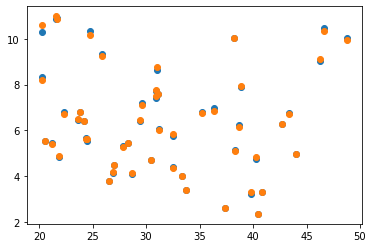

In [66]:
#NEW AFTERNOON
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(7)
w =np.ones(7)
w_o =np.ones(7)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model6b

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

In [46]:
#first define price and rest of variables
p = rand.uniform(20,50,50)
q = rand.uniform(0,1,50)
r = rand.uniform(0.01,0.04,50)
s = rand.uniform(0,1,50)
t = rand.uniform(0,1,50)
z = rand.uniform(0,1,50)


#dataframe
dades = {'p':p,'q':q,'r':r,'s':s,'t':t,'z':z}
sim1 = pd.DataFrame(data=dades)
gen_params = [2.5,0.1,0.8,0.5,0.2,1.1,0.1]
sim1['d'] = model6b_data(sim1.values,gen_params,0.1)
print(sim1.shape)
sim1.head(5)

(50, 7)


p         q         r         s         t         z         d
0  21.824464  0.496896  0.019406  0.899876  0.661620  0.839121  4.842037
1  38.843655  0.442240  0.022232  0.231027  0.647282  0.009793  7.876732
2  38.274946  0.703294  0.033803  0.490006  0.211731  0.397970  5.149573
3  46.300849  0.279181  0.016125  0.137051  0.532246  0.598878  9.050166
4  26.888050  0.798240  0.022383  0.831727  0.670246  0.810055  4.151047

nit 0  w:  [1.00132203 0.99838996 0.99989699 0.99999937 0.99999252 0.99898879
 0.99921731] grad [-1.32203464e+01  1.61004018e+01  1.03005462e+00  6.34819470e-03
  7.47512490e-02  1.01121250e+01  7.82687136e+00] loss 467.7513952337101 time 0.005982875823974609
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 1.6806999999999997e-05
eta 1.1764899999999996e-05
eta 8.235429999999996e-06
eta 5.764800999999997e-06
eta 4.035360699999998e-06
eta 2.8247524899999986e-06
eta 1.977326742999999e-06
eta 1.3841287200999992e-06
eta 9.688901040699995e-07
eta 6.782230728489996e-07
eta 4.747561509942997e-07
eta 3.3232930569600976e-07
eta 2.326305139872068e-07
eta 1.6284135979104476e-07
eta 1.1398895185373132e-07
eta 7.979226629761192e-08
eta 5.5854586408328346e-08
eta 3.909821048582984e-08
eta 2.7368747340080887e-08
eta 1.915812313805662e-08
eta 1.3410686196639634e-08
eta 9.387480337647743e-09
eta 6.57123623635342e-09
eta 4.5998653654473935e-09
eta 3.2199057558

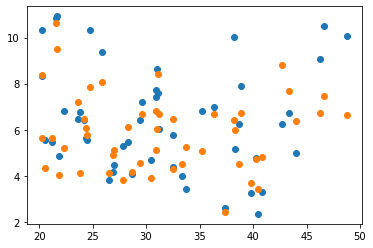

In [47]:
#NEW
X = sim1.values[:,:-1]
d = sim1.values[:,-1]
w =np.ones(7)
w =np.ones(7)
w_o =np.ones(7)
loss = 10e10
loss_o = 10e11
Niterations = 10000000
eta=0.0001
nit=0
used_model = model6b

start_time = time.time()

while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
    if loss>loss_o:
        eta = eta*0.7
        print('eta',eta) 
    w_o = w
    loss_o = loss
    
    gradients = my_training_gradient2(d, X, w, model=used_model)
    w -= eta*gradients
    
    loss = my_autograd_loss2(d,X,w,model=used_model)
    #print(nit, loss, w_o, w)
    
    if nit % 1000000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
    nit+=1

print("nit",nit)

print("Generative params")
print(gen_params)
print("Estimated params")
print(w)
print('loss: ',my_autograd_loss2(d,X,w,model=used_model))

print("Real values:")
print(d)
print("Predicted values:")
d_p = used_model(X,w)
print(d_p)
plt.scatter(X[:,0],d)
plt.scatter(X[:,0],d_p)

### Real Data
We first prepare our data for the model. In order to represent the periodicity of the weeks we use sinus and cos. 

In [18]:
products = ['Suede And Nubuck Brush',"Hotter Women's Insoles",'Footwear Cleaner','Renovating Cream', 'Wax Oil','Shake','Rutland GTX','Laurel', 'Leanne','Solar','Nova', 'Tone']

In [19]:
data = pd.read_csv('../Data/TFM_Hdataset_clean.csv', index_col=0)


conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']!= 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)
data = data[(data['Year']!=2021)&(data['Year']!=2020)&(data['Year']!=2019)]
data

Description Seasonality  Year  Week    Channel        WSSI Category  \
0           Astrid         OLD  2017     1  DE Direct  Womens Active Shoes   
1        Charmaine          SS  2017     1  DE Direct  Womens Formal Shoes   
2            Chile          SS  2017     1  DE Direct  Womens Casual Shoes   
3         Devotion          AW  2017     1  DE Direct      Womens Slippers   
4            Donna        CONT  2017     1  DE Direct  Womens Formal Shoes   
...            ...         ...   ...   ...        ...                  ...   
155151        Wrap         OLD  2018    52  Wholesale      Womens Slippers   
155152        Wrap          SS  2018    52  Wholesale      Womens Slippers   
155153        Wrap          AW  2018    52  Wholesale      Womens Slippers   
155154        York          AW  2018    52  Wholesale  Womens Formal Boots   
155155        Zara          AW  2018    52  Wholesale  Womens Formal Shoes   

        LIMITED EDITION STYLES  Originals        Source  sales  ...  \
0                          0.0        0.0          NONE    1.0  ...   
1                          0.0        0.0          NONE    1.0  ...   
2                          0.0        0.0          NONE    1.0  ...   
3                          0.0        0.0          NONE    2.0  ...   
4                          0.0        0.0          NONE    1.0  ...   
...                        ...        ...           ...    ...  ...   
155151                     0.0        0.0  MANUFACTURED    1.0  ...   
155152                     0.0        0.0  MANUFACTURED   22.0  ...   
155153                     0.0        0.0  MANUFACTURED   37.0  ...   
155154                     0.0        0.0  MANUFACTURED   89.0  ...   
155155                     0.0        0.0       SOURCED   17.0  ...   

           Margin        RRP   Markdown       Cost  month  Channel2  \
0       25.758448  50.378410  11.851731  12.768232      1        US   
1       44.100962  58.395499   0.169733  14.124805      1        US   
2       46.649675  58.395499   0.169733  11.576091      1        US   
3       17.882101  34.688819   8.231530   8.575187      1        US   
4       54.114939  70.192570   0.209836  15.867796      1        US   
...           ...        ...        ...        ...    ...       ...   
155151   9.710000  45.833333  20.623333  14.240000     12        UK   
155152  11.712727  49.166666  23.956666  13.440000     12        UK   
155153   4.329459  49.166666  31.397207  13.440000     12        UK   
155154  11.904719  79.166666  47.205206  20.056742     12        UK   
155155   7.911765  70.833333  40.861568  22.060000     12        UK   

        CategoryCluster ProductCluster      Week_sin  Week_cos  
0             Cluster 6      Cluster 2  1.205367e-01  0.992709  
1             Cluster 0      Cluster 2  1.205367e-01  0.992709  
2             Cluster 3      Cluster 7  1.205367e-01  0.992709  
3             Cluster 0      Cluster 2  1.205367e-01  0.992709  
4             Cluster 0      Cluster 7  1.205367e-01  0.992709  
...                 ...            ...           ...       ...  
155151        Cluster 0      Cluster 2  6.432491e-16  1.000000  
155152        Cluster 0      Cluster 2  6.432491e-16  1.000000  
155153        Cluster 0      Cluster 2  6.432491e-16  1.000000  
155154        Cluster 0      Cluster 6  6.432491e-16  1.000000  
155155        Cluster 0      Cluster 6  6.432491e-16  1.000000  

[155156 rows x 30 columns]

We will focus on the products with more data for UK Direct

Product Suede And Nubuck Brush
Channel UK Direct
nit 35401
Estimated params
[ 4.82417644 -0.17508778 -0.12646606 -3.52213772  1.36379156 -0.14654148]
loss:  545.2140760825811


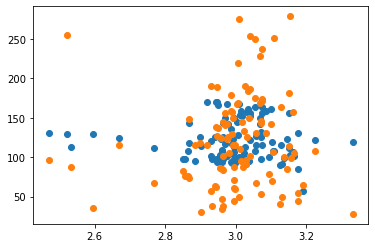

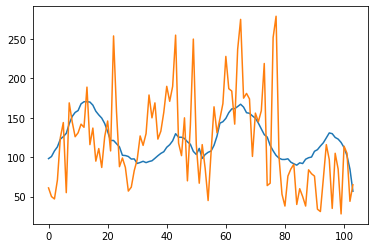

Product Suede And Nubuck Brush
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
nit 5318
Estimated params
[ 5.42813872 -0.06681849  0.28604419  2.37152974  0.04205785 -0.27965804]
loss:  484.28149518029693


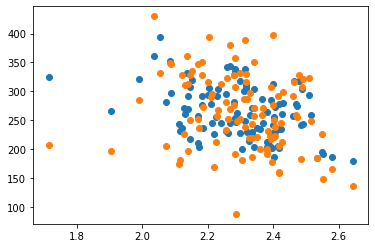

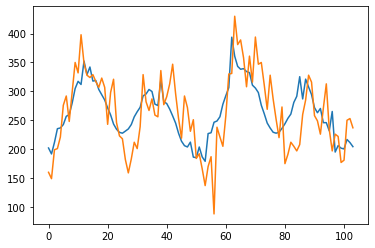

Product Hotter Women's Insoles
Channel UK Direct
nit 11215
Estimated params
[ 3.41713797 -0.04397155  0.12243144 -0.00513865  1.00050508 -0.0324457 ]
loss:  150.36632616583915


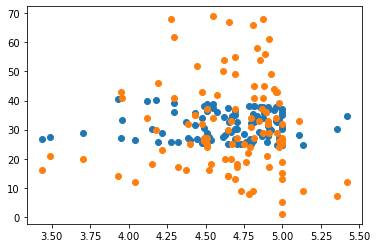

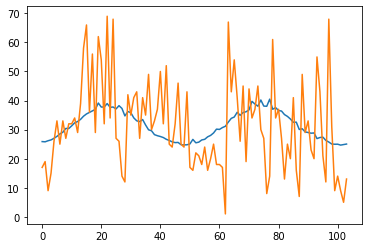

Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
nit 1997
Estimated params
[ 5.83845363  0.05672088  0.22157189  4.73060546  0.86057687 -0.41770643]
loss:  499.4965034944225


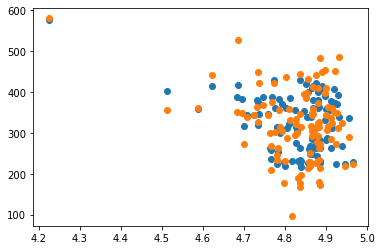

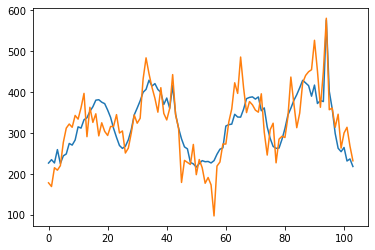

Product Footwear Cleaner
Channel UK Direct
nit 22562
Estimated params
[ 5.69213779 -0.15682329  0.10604664 -0.19418903  1.0141934   0.51575719]
loss:  1227.7565471300006


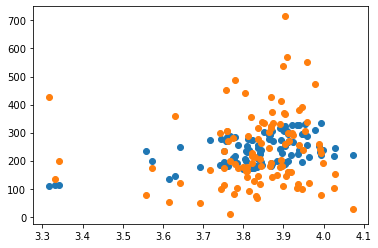

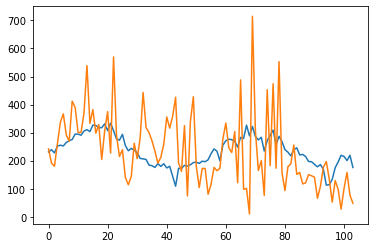

Product Footwear Cleaner
Channel Retail - Full Price
eta 7e-05
eta 4.899999999999999e-05
nit 5346
Estimated params
[ 6.03079999 -0.18470134  0.26545885  2.63028946  0.85602449 -0.37200059]
loss:  816.1052120388715


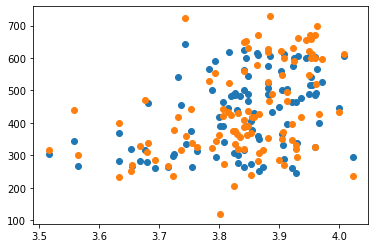

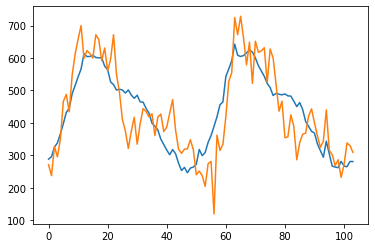

Product Renovating Cream
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


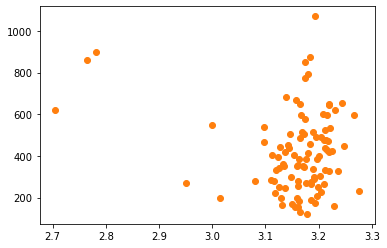

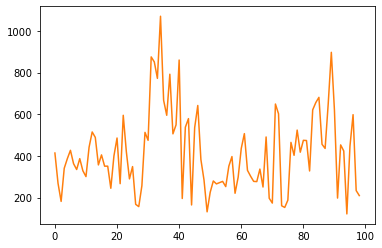

Product Renovating Cream
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


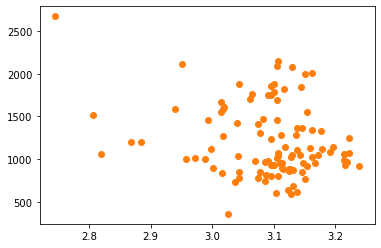

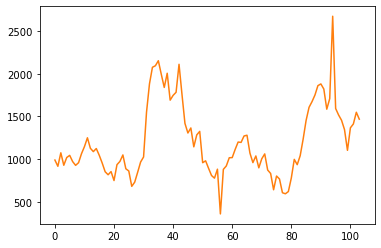

Product Wax Oil
Channel UK Direct
nit 12356
Estimated params
[ 1.61774434  0.20187869 -0.13113322  0.10305405  0.98495262 -0.03960309]
loss:  32.68776208929272


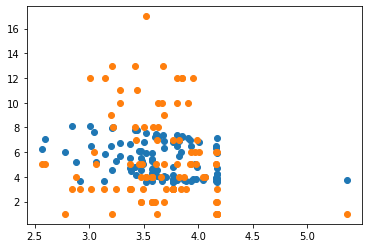

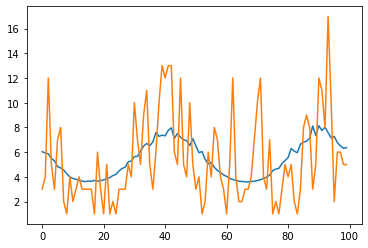

Product Wax Oil
Channel Retail - Full Price
nit 67700
Estimated params
[ 3.42433627  0.31248593 -0.12705583 -0.41661325  1.02885018  0.16403066]
loss:  155.7736823468206


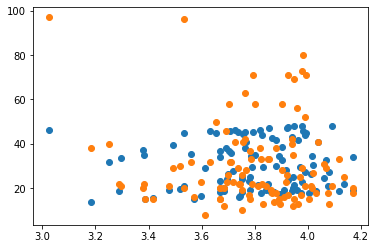

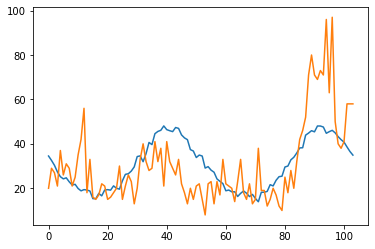

Product Shake
Channel UK Direct
nit 1
Estimated params
[-3.58320953e+43 -9.29916698e+43  1.12912330e+43 -1.31250370e+43
  4.42413257e+45 -3.80600158e+45]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


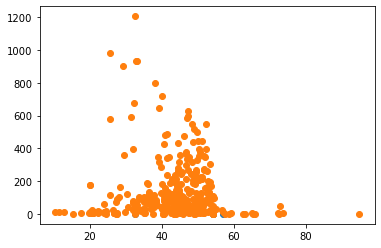

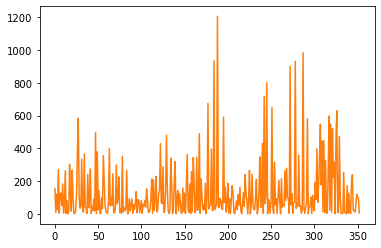

Product Shake
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


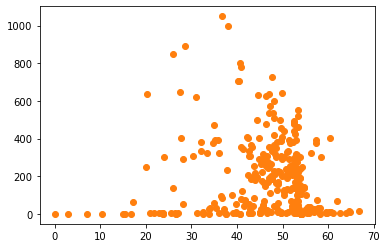

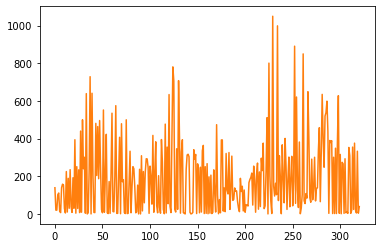

Product Rutland GTX
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


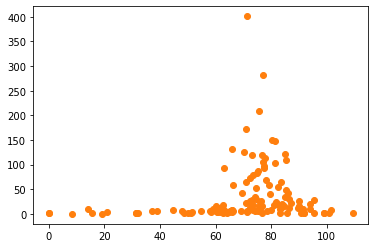

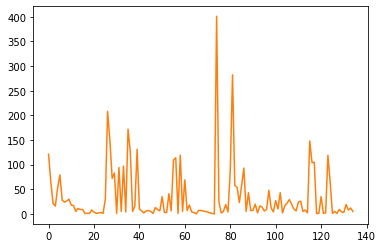

Product Rutland GTX
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


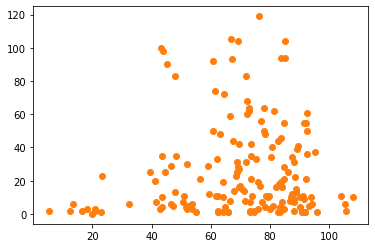

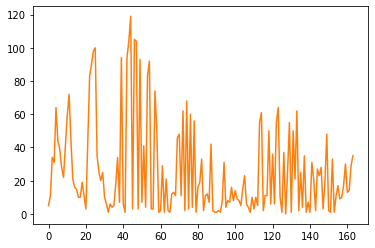

Product Laurel
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


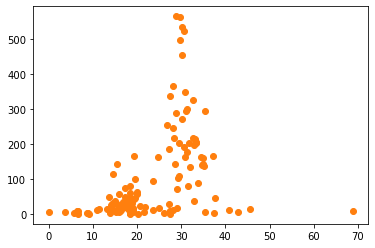

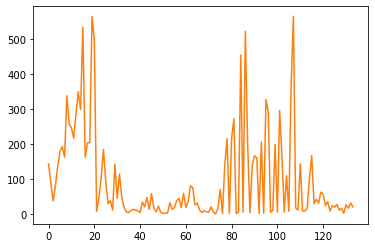

Product Laurel
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


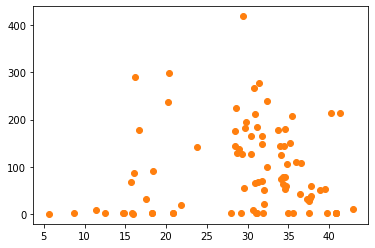

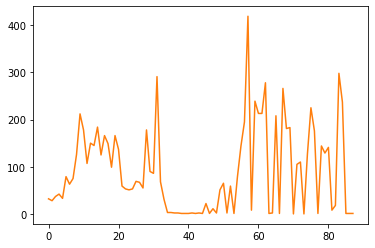

Product Leanne
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


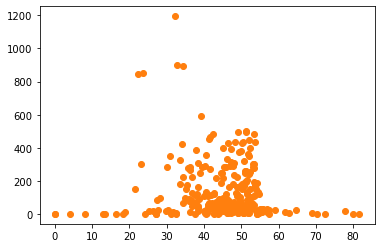

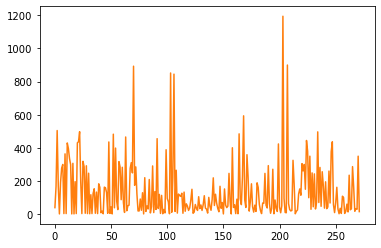

Product Leanne
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


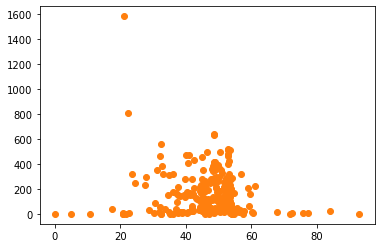

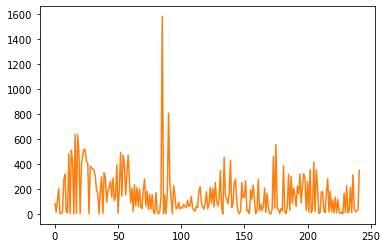

Product Solar
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


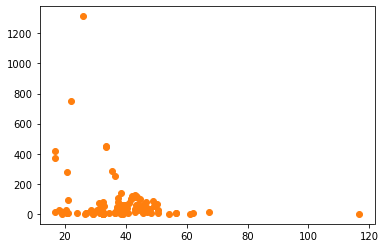

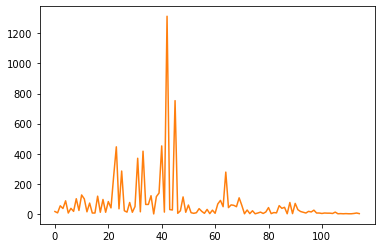

Product Solar
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


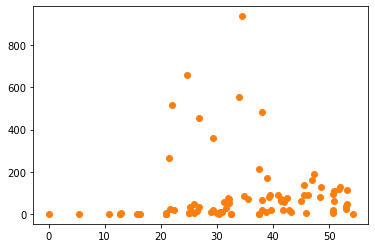

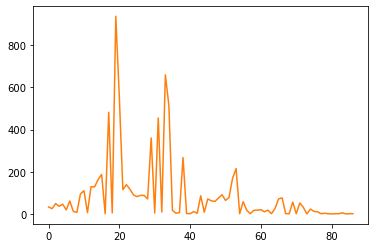

Product Nova
Channel UK Direct
nit 1
Estimated params
[-1.12771147e+33 -3.74068107e+33 -9.21995077e+32  2.18688875e+32
  2.14471039e+34 -9.04212623e+34]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


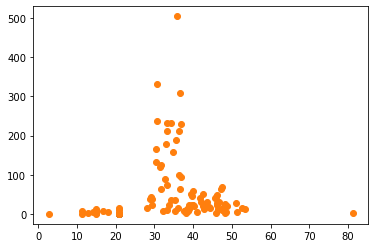

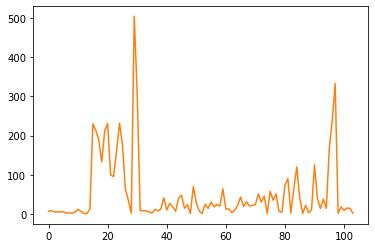

Product Nova
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


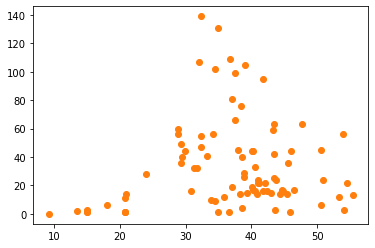

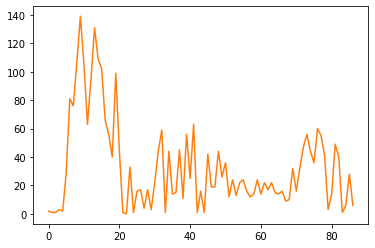

Product Tone
Channel UK Direct
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


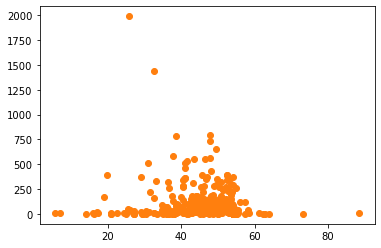

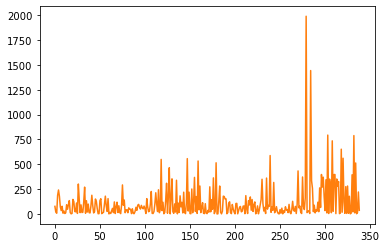

Product Tone
Channel Retail - Full Price
nit 1
Estimated params
[nan nan nan nan nan nan]
loss:  nan


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


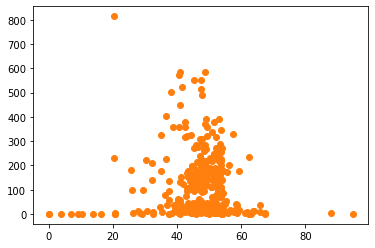

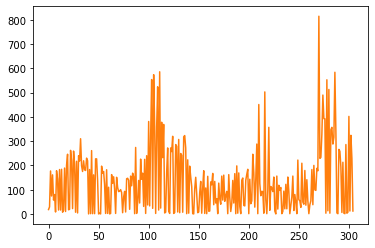

In [187]:
#ALL PRODUCTS
model_used = model6b

for prod in products:
    for channel in ['UK Direct','Retail - Full Price']:
        #data_prod = data[(data['Description']==prod)&(data['Channel']==channel)].groupby(['Date'], as_index=False).agg(aggregations)
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','RRP','sales']]
        data_prod = data_prod.fillna(0)

        X = data_prod.values[:,:-1]
        d = data_prod.values[:,-1]
        w = np.ones(6)
        w_o = np.ones(6)
        loss = 10e10
        loss_o = 10e11
        Niterations = 1000000
        eta=0.0001
        nit=0
        print("Product",prod)
        print("Channel",channel)

        start_time = time.time()

        while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
            if loss>loss_o:
                eta = eta*0.7
                print('eta',eta) 
            w_o = w
            loss_o = loss

            gradients = my_training_gradient(d, X, w, model=used_model)
            w -= eta*gradients

            loss = my_autograd_loss(d,X,w,model=used_model)
            #print(nit, loss)

            #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
            nit+=1


        print("nit",nit)

        print("Estimated params")
        print(w)
        print('loss: ',my_autograd_loss(d,X,w,model=used_model))


        #print("Predicted values:")
        #print(used_model(X,w))

        plt.scatter(X[:,0],used_model(X,w))
        plt.scatter(X[:,0],d)
        plt.show()

        plt.plot(used_model(X,w))
        plt.plot(d)
        plt.show()


Let's try different initializations to see if we overcome the local minima.

Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  544.7116568824197
nit 1000000
initialization:  0.5
estimated parameters: [ 4.36246328 -0.06449881  0.02236084 -5.00015502  1.23794436 -0.69968159
  3.42495101]


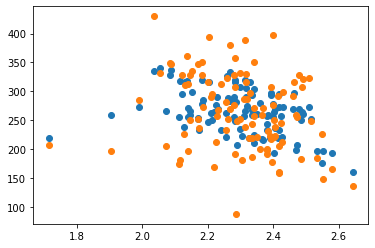

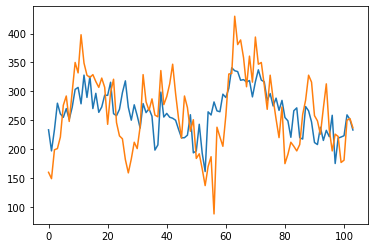

loss:  544.5266327433299
nit 1000000
initialization:  1.0
estimated parameters: [ 4.37821867 -0.06050502  0.02098663 -5.95795459  1.32696298 -0.64741179
  4.14270652]


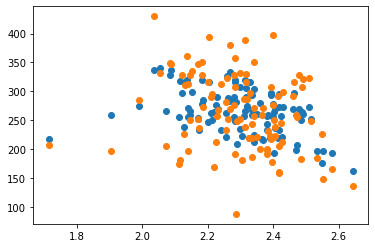

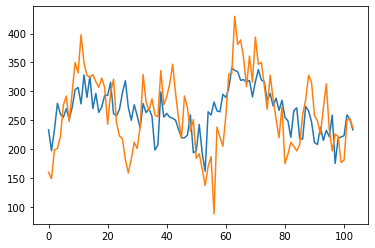

loss:  544.4463939358474
nit 1000000
initialization:  1.5
estimated parameters: [ 4.38535138 -0.0588385   0.02041391 -6.44960081  1.37033452 -0.62561836
  4.51089638]


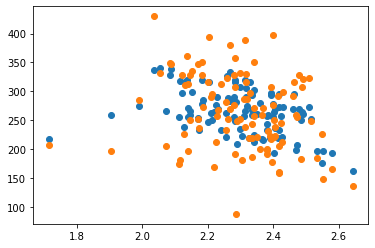

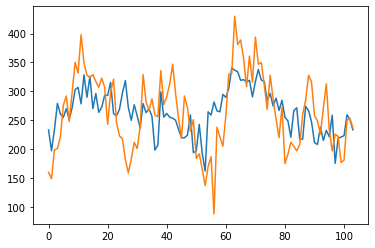

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  681.428329771253
nit 1000000
initialization:  0.5
estimated parameters: [ 5.72947633  1.23355263  1.40462135 -1.07762473  1.52800585 -2.91528633
 -1.32554339]


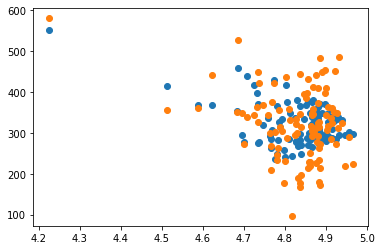

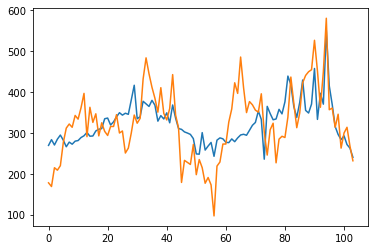

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price
loss:  805.0217293008136
nit 1000000
initialization:  0.5
estimated parameters: [ 5.80859413 -0.93424582  0.72224135  0.46325213 -1.14039194 -3.75491222
  1.56255327]


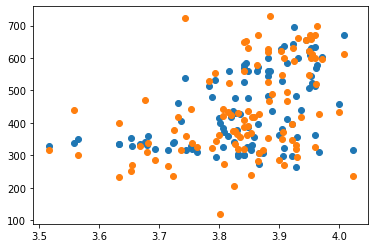

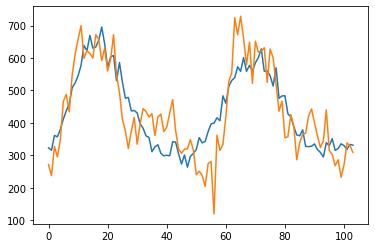

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
loss:  2643.8798303682615
nit 1000000
initialization:  0.5
estimated parameters: [ 6.93008887  0.29171254 -0.04850209 10.206133   -0.69186038 -0.45402879
  1.00783106]


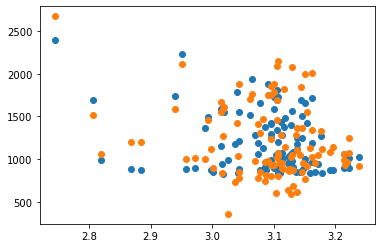

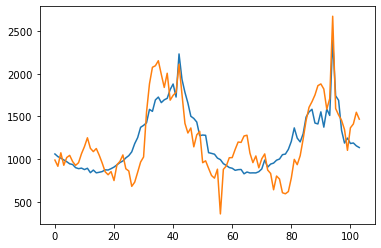

loss:  2643.860563441319
nit 1000000
initialization:  1.0
estimated parameters: [ 6.93008619  0.29134174 -0.04843393 10.23649911 -0.6940153  -0.45341876
  1.00943035]


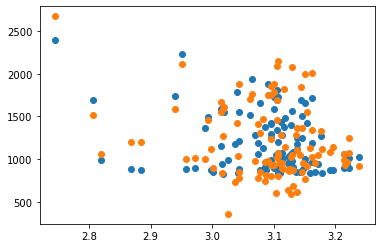

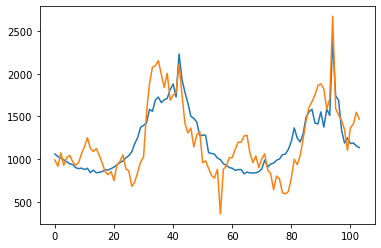

loss:  2642.5953223661472
nit 1000000
initialization:  1.5
estimated parameters: [ 6.92992394  0.26927634 -0.04437511 12.37435386 -0.84543187 -0.41698034
  1.11833689]


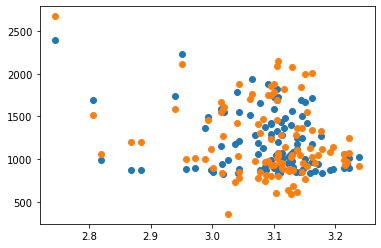

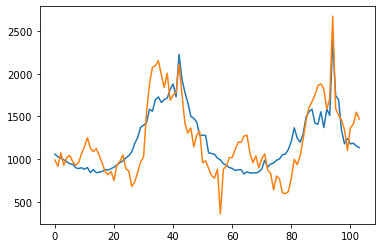

loss:  2642.538591140988
nit 1000000
initialization:  2.0
estimated parameters: [ 6.92991728  0.26838556 -0.04421105 12.47669384 -0.85266397 -0.4155027
  1.12338088]


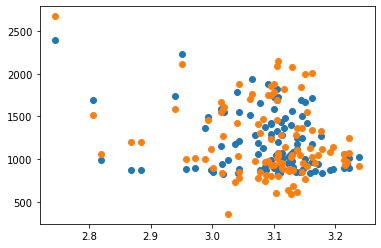

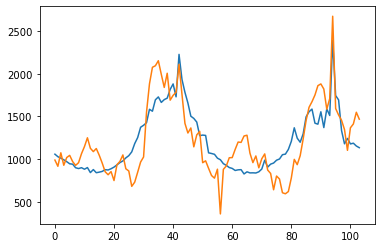

Product Wax Oil
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  147.02600198218946
nit 1000000
initialization:  0.5
estimated parameters: [ 3.35192597  3.52192655 -1.36331783 -0.30116641  0.54636211  0.90862807
 -0.27673329]


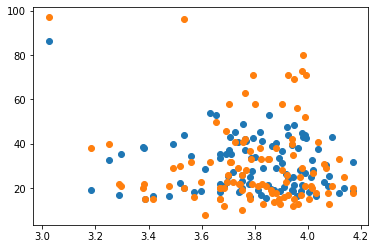

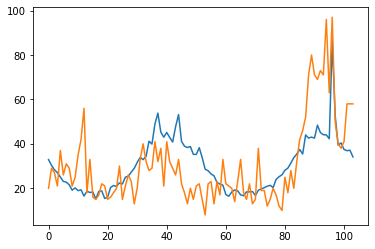

loss:  146.70656646732053
nit 1000000
initialization:  2.0
estimated parameters: [ 3.32805685 -3.66567945  1.38610343  0.19917083  0.03810547 -0.21263026
  0.17554318]


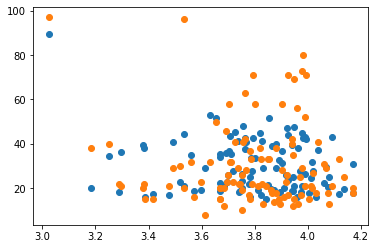

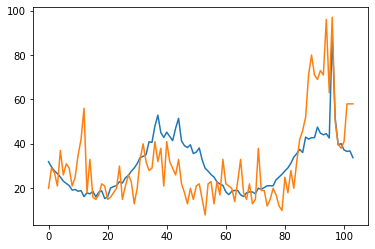

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:78: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encou

In [52]:
#RUNING at 6
#ALL PRODUCTS LOSS WITH RRP 
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model6b

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','RRP','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(7)
            w_o = i/2*np.ones(7)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




Let's try with the evoluited loss

Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  544.4442239225629
nit 1000000
initialization:  1.0
estimated parameters: [ 4.38486459 -0.05882447  0.02038879 -5.08888301  1.39836356 -0.62539528
  5.88967142]


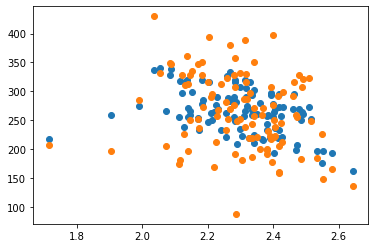

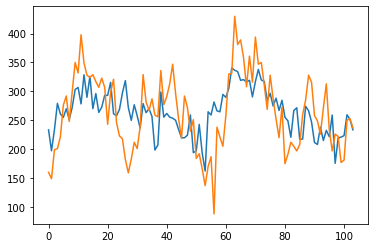

loss:  544.4392874522536
nit 1000000
initialization:  1.5
estimated parameters: [ 4.38531168 -0.05872297  0.02035398 -5.11821748  1.40125517 -0.62406852
  5.91650022]


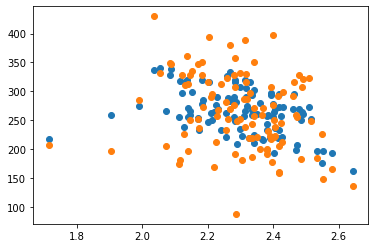

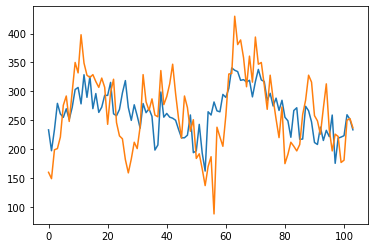

loss:  544.424978233535
nit 1000000
initialization:  2.0
estimated parameters: [ 4.38661254 -0.05842943  0.02025331 -5.20442785  1.40972401 -0.62023148
  5.99528163]


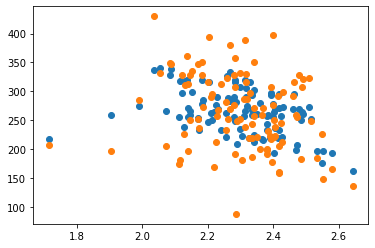

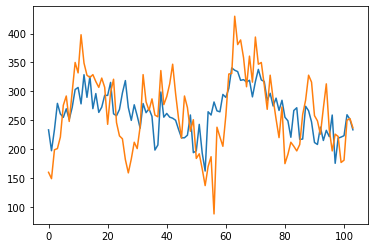

loss:  544.4202743652063
nit 1000000
initialization:  2.5
estimated parameters: [ 4.38704178 -0.05833314  0.02022029 -5.23315727  1.41253684 -0.61897294
  6.02151407]


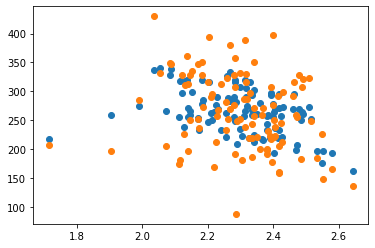

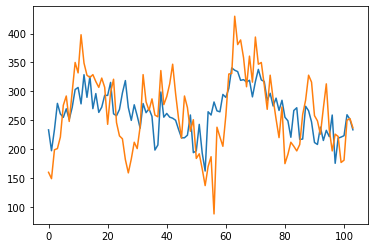

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  681.1958768708513
nit 1000000
initialization:  0.5
estimated parameters: [ 5.72952852  1.38590608  1.5817427   0.41936548  1.37030045 -3.27487214
  0.20223882]


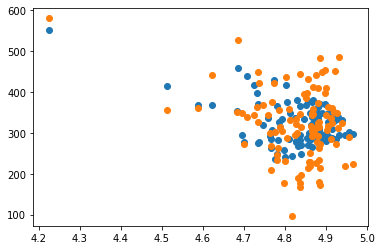

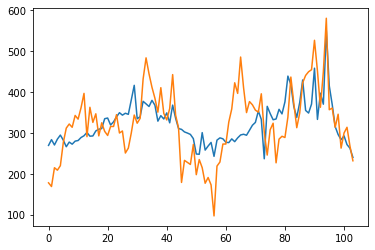

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  804.9055588804085
nit 1000000
initialization:  0.5
estimated parameters: [ 5.80978848 -1.0363736   0.80197338 -0.56797395 -0.95588018 -4.13771596
  0.40041677]


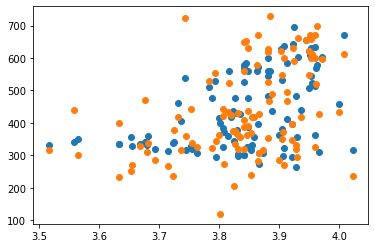

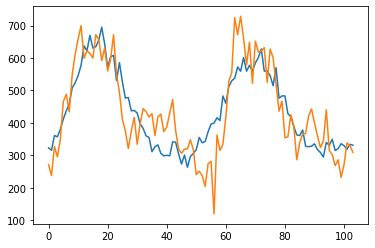

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
Product Wax Oil
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  146.99424656125578
nit 1000000
initialization:  0.5
estimated parameters: [ 3.35255356  4.11387777 -1.58922375  0.24545478  0.495815    1.07752564
  0.26511381]


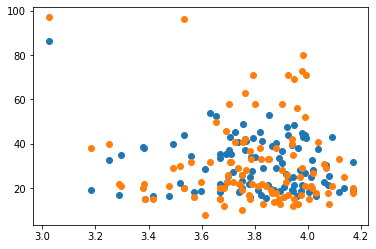

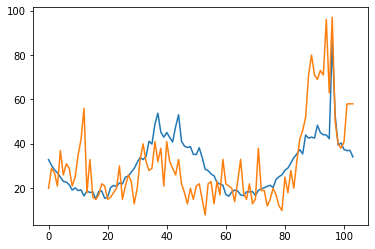

loss:  146.99416283181483
nit 1000000
initialization:  1.0
estimated parameters: [ 3.3525553   4.11569592 -1.58991747  0.24545486  0.49568532  1.07804804
  0.26510207]


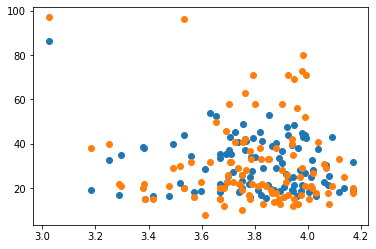

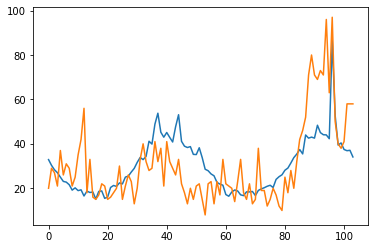

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:78: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.log,   

In [53]:
#running at 6b
#ALL PRODUCTS LOSS WITH MARKDOWN  
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model6b

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','Markdown','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(7)
            w_o = i/2*np.ones(7)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  540.6858130627276
nit 1000000
initialization:  0.5
estimated parameters: [ 4.53409529 -0.05170078  0.02214549 -7.65164568  1.83985891 -0.50708108
  5.95988095]


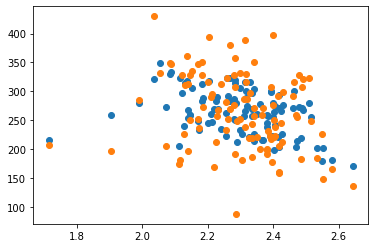

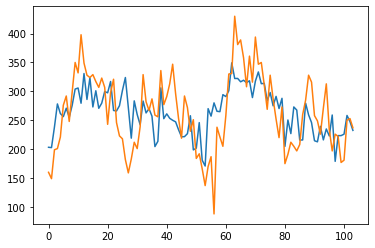

loss:  540.6401231381451
nit 1000000
initialization:  1.0
estimated parameters: [ 4.53594017 -0.05124563  0.02194488 -7.89849925  1.90392741 -0.50147992
  6.10206914]


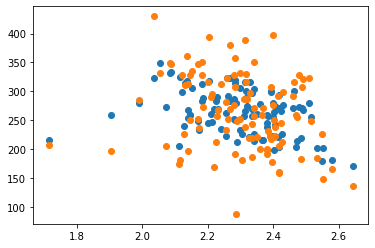

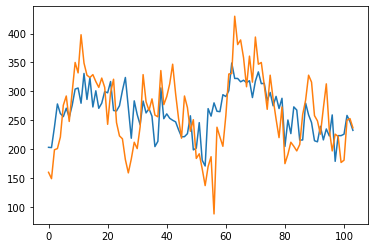

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  723.6287316656784
nit 1000000
initialization:  0.5
estimated parameters: [ 5.69809998  0.07171455  0.07555052  4.07815651  0.77443385 -0.34870942
  0.21547215]


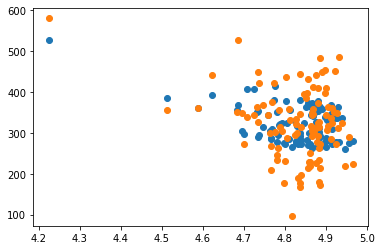

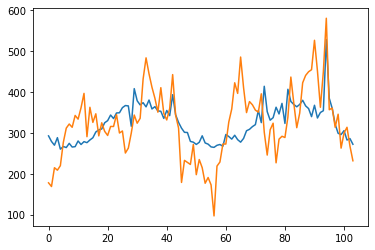

loss:  723.6287039904514
nit 1000000
initialization:  1.0
estimated parameters: [ 5.69809885  0.07168655  0.07552127  4.08196248  0.77508131 -0.34857881
  0.21543885]


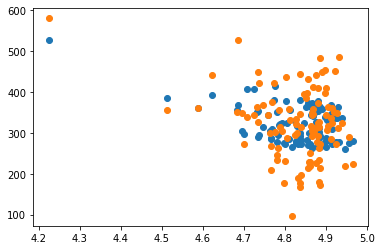

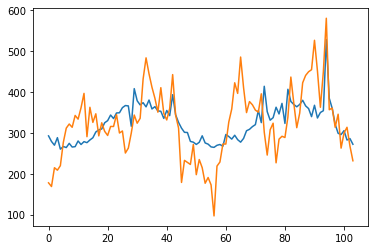

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price
loss:  808.4836335274778
nit 1000000
initialization:  0.5
estimated parameters: [ 5.91370823 -1.7049693   1.35986708 -0.25820421  0.02712276 -3.30790766
  0.29491122]


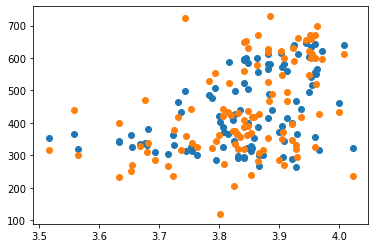

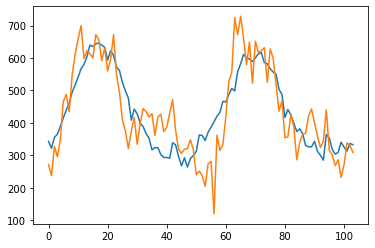

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
loss:  2671.080053532372
nit 1000000
initialization:  0.5
estimated parameters: [ 6.96012301  2.21707027 -0.54807581  0.485734    0.12571866 -3.70064631
  0.22581988]


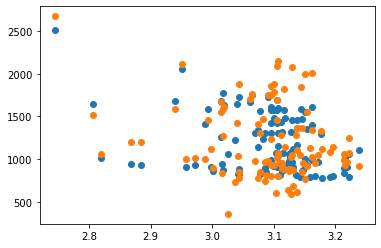

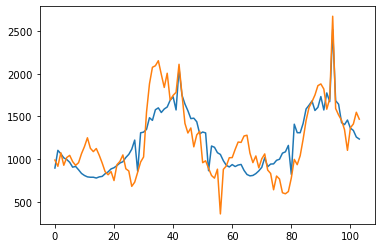

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Wax Oil
Channel Retail - Full Price
loss:  151.41180646745102
nit 1000000
initialization:  1.0
estimated parameters: [ 3.41849581e+00  2.82924096e-01 -1.11030569e-01  8.14594583e-01
  1.40852125e+00  1.42857529e-01  1.72360292e-04]


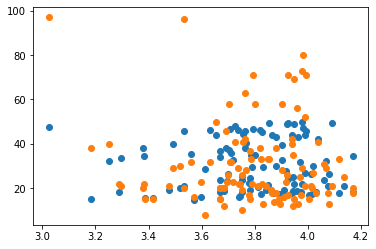

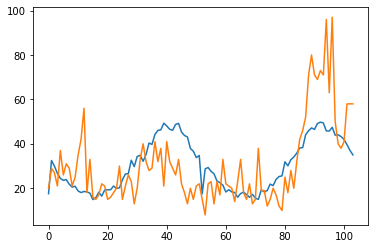

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


loss:  142.48382280562308
nit 887157
initialization:  2.0
estimated parameters: [ 3.35511025 -0.69440983  0.27833327  0.43174277 -0.30838678 -0.1395524
  0.41326461]


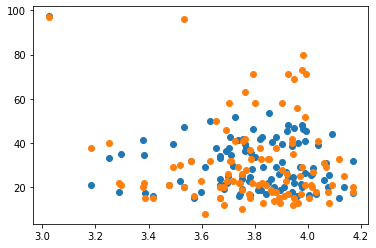

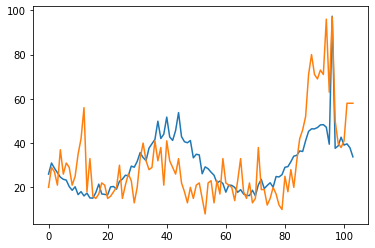

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_12448/1094504923.py:36: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:


In [54]:
#running at 6c
#ALL PRODUCTS LOSS WITH MARKDOWN  
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model6b

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(7)
            w_o = i/2*np.ones(7)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




### Residual

Product Suede And Nubuck Brush
Channel Retail - Full Price
eta 7e-05
eta 7e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
eta 7e-05
eta 4.899999999999999e-05
eta 3.4299999999999993e-05
eta 2.4009999999999995e-05
Product Hotter Women's Insoles
Channel Retail - Full Price
eta 7e-05
Product Footwear Cleaner
Channel Retail - Full Price
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
eta 7e-05
Product Renovating Cream
Channel Retail - Full Price
Product Wax Oil
Channel Retail - Full Price
loss:  274.9560578158668
initialization:  -0.5


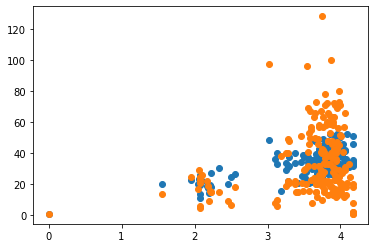

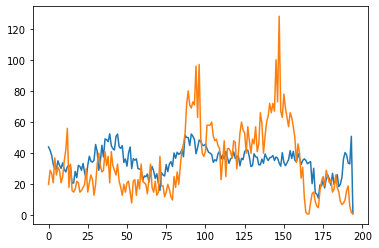

loss:  274.9560578158664
initialization:  1.5


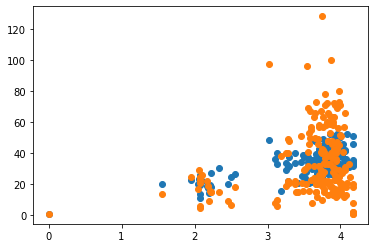

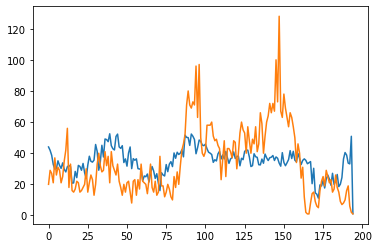

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


In [184]:
#ALL PRODUCTS
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
used_model = model6b

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        series = data_prod[['Date','sales']].groupby(['Date']).sum()
        
        result = seasonal_decompose(series, model='additive', period=5)
        residual = pd.DataFrame(result.resid)
        trend = pd.DataFrame(result.trend)
        trend = trend.rename(columns={'trend':'resid'})
        desc = residual.add(trend,fill_value=0)
        data_prod = data_prod.merge(desc, on='Date')        
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','RRP','prev_mean_price','sales']]
        data_prod = data_prod.fillna(0)



Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  13793.870859192071
nit 896
initialization:  1.0
estimated parameters: [ 2.35635635  1.56648406  0.6937776   0.96740744  0.91447317 -0.49210932
  1.16753199]


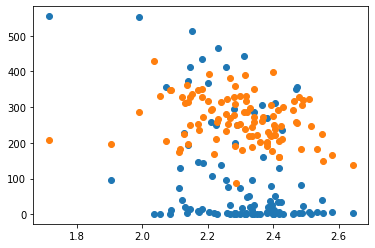

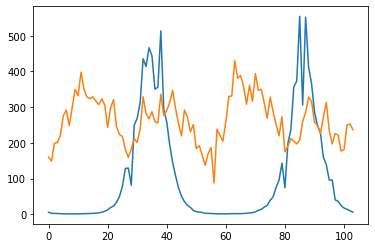

loss:  12089.96246251928
nit 913
initialization:  1.5
estimated parameters: [1.96226931 2.28191476 0.79470681 1.49303748 1.40660539 0.5418934
 1.45366462]


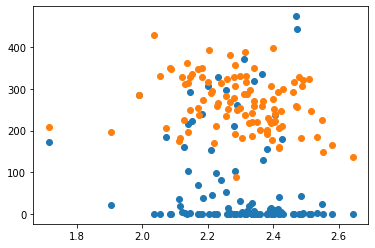

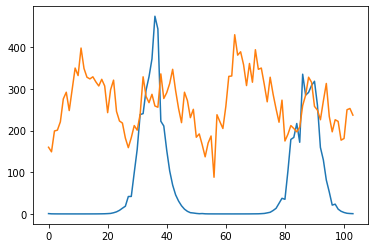

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price
loss:  20541.07333834388
nit 108748
initialization:  1.5
estimated parameters: [ 2.54075545 -1.16468161  1.66211513  1.5114058   1.24392855  1.06547701
  1.40725754]


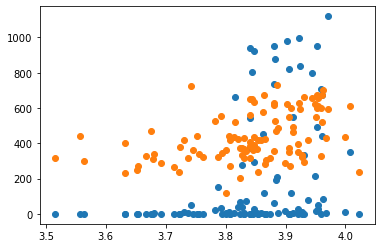

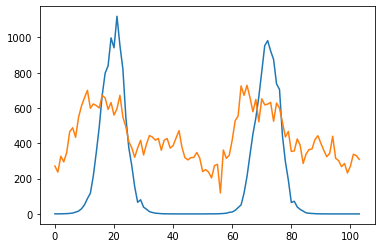

Product Renovating Cream
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Wax Oil
Channel Retail - Full Price
loss:  1334.4221520935253
nit 339
initialization:  0.5
estimated parameters: [ 1.47096028  1.39163755 -0.18899516  0.55523543  1.22500666  0.00898765
  0.73515878]


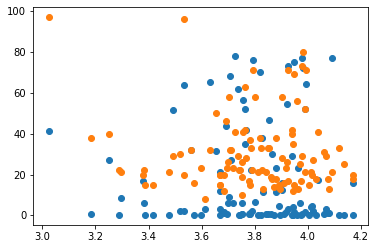

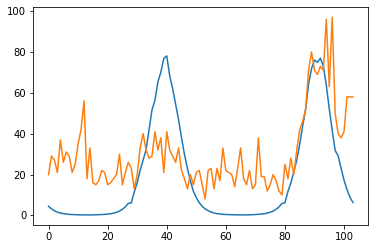

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


In [73]:
#ALL PRODUCTS LOSS 2
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model6b

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 50000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(7)
            w_o = i/2*np.ones(7)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient2(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss2(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss2(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  540.6858130627276
nit 1000000
initialization:  0.5
estimated parameters: [ 4.53409529 -0.05170078  0.02214549 -7.65164568  1.83985891 -0.50708108
  5.95988095]


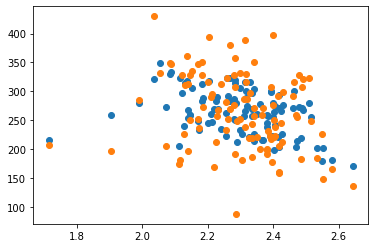

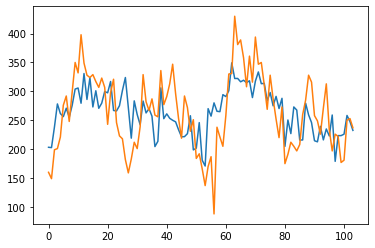

loss:  540.6401231381451
nit 1000000
initialization:  1.0
estimated parameters: [ 4.53594017 -0.05124563  0.02194488 -7.89849925  1.90392741 -0.50147992
  6.10206914]


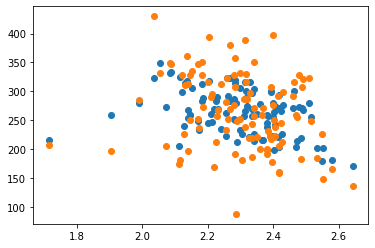

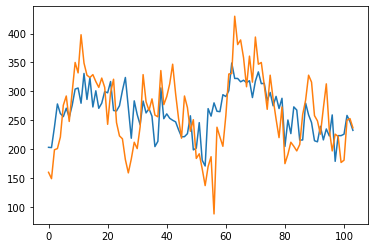

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  723.6287316656784
nit 1000000
initialization:  0.5
estimated parameters: [ 5.69809998  0.07171455  0.07555052  4.07815651  0.77443385 -0.34870942
  0.21547215]


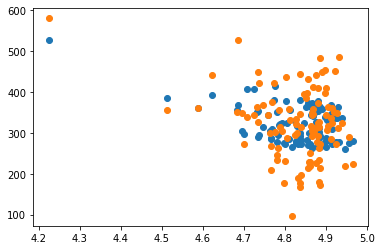

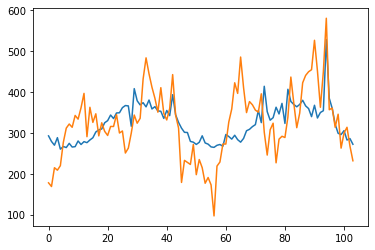

loss:  723.6287039904514
nit 1000000
initialization:  1.0
estimated parameters: [ 5.69809885  0.07168655  0.07552127  4.08196248  0.77508131 -0.34857881
  0.21543885]


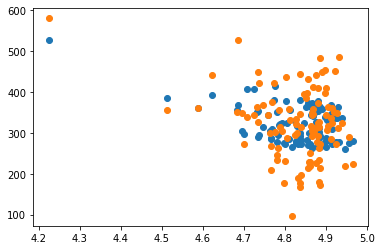

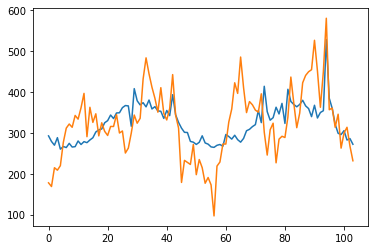

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price
loss:  808.4836335274778
nit 1000000
initialization:  0.5
estimated parameters: [ 5.91370823 -1.7049693   1.35986708 -0.25820421  0.02712276 -3.30790766
  0.29491122]


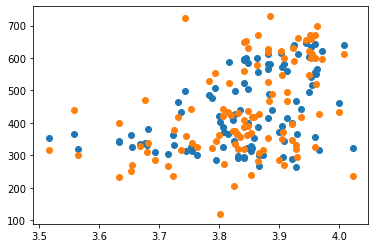

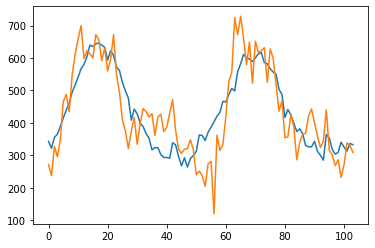

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
loss:  2671.080053532372
nit 1000000
initialization:  0.5
estimated parameters: [ 6.96012301  2.21707027 -0.54807581  0.485734    0.12571866 -3.70064631
  0.22581988]


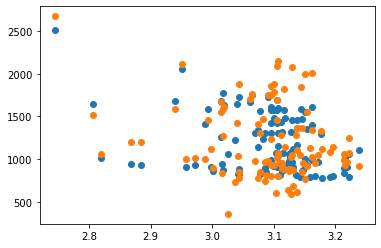

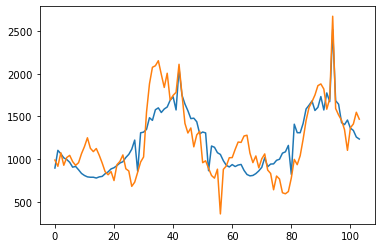

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Wax Oil
Channel Retail - Full Price
loss:  151.41180646745102
nit 1000000
initialization:  1.0
estimated parameters: [ 3.41849581e+00  2.82924096e-01 -1.11030569e-01  8.14594583e-01
  1.40852125e+00  1.42857529e-01  1.72360292e-04]


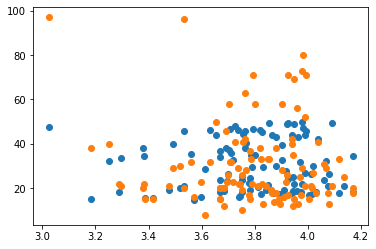

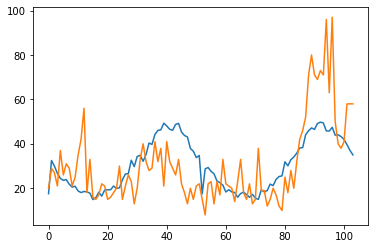

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


loss:  142.48382280562308
nit 887157
initialization:  2.0
estimated parameters: [ 3.35511025 -0.69440983  0.27833327  0.43174277 -0.30838678 -0.1395524
  0.41326461]


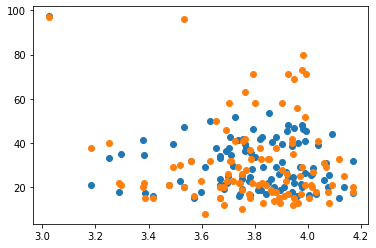

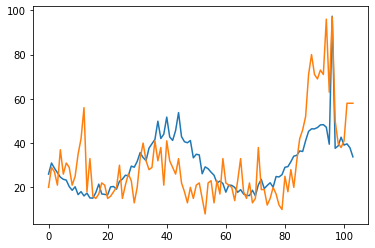

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_12448/2633852947.py:36: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:


In [60]:
#running at 6c
#ALL PRODUCTS LOSS WITH MARKDOWN  
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model7

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(7)
            w_o = i/2*np.ones(7)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  540.6858130627276
nit 1000000
initialization:  0.5
estimated parameters: [ 4.53409529 -0.05170078  0.02214549 -7.65164568  1.83985891 -0.50708108
  5.95988095  0.5       ]


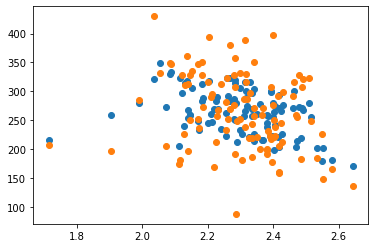

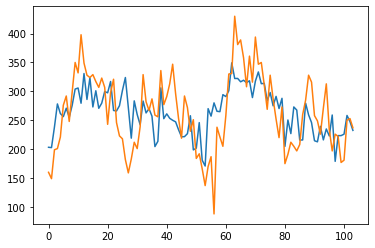

loss:  540.6401231381451
nit 1000000
initialization:  1.0
estimated parameters: [ 4.53594017 -0.05124563  0.02194488 -7.89849925  1.90392741 -0.50147992
  6.10206914  1.        ]


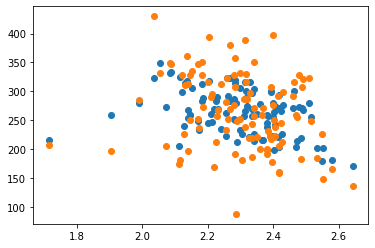

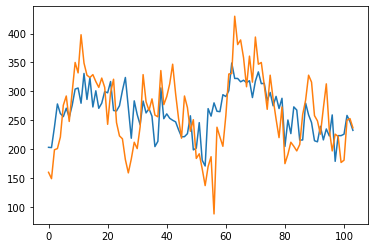

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  723.6287316656784
nit 1000000
initialization:  0.5
estimated parameters: [ 5.69809998  0.07171455  0.07555052  4.07815651  0.77443385 -0.34870942
  0.21547215  0.5       ]


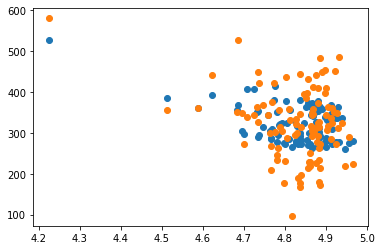

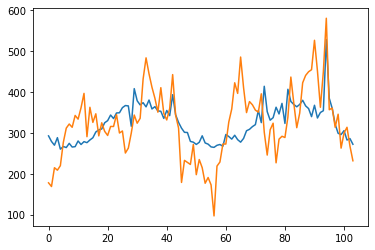

loss:  723.6287039904514
nit 1000000
initialization:  1.0
estimated parameters: [ 5.69809885  0.07168655  0.07552127  4.08196248  0.77508131 -0.34857881
  0.21543885  1.        ]


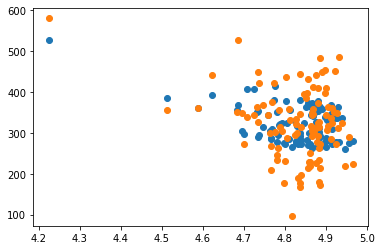

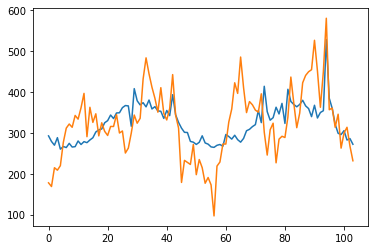

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price
loss:  808.4836335274778
nit 1000000
initialization:  0.5
estimated parameters: [ 5.91370823 -1.7049693   1.35986708 -0.25820421  0.02712276 -3.30790766
  0.29491122  0.5       ]


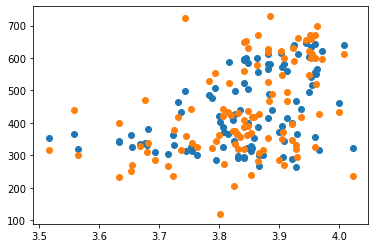

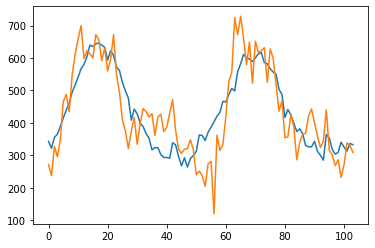

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
loss:  2671.080053532372
nit 1000000
initialization:  0.5
estimated parameters: [ 6.96012301  2.21707027 -0.54807581  0.485734    0.12571866 -3.70064631
  0.22581988  0.5       ]


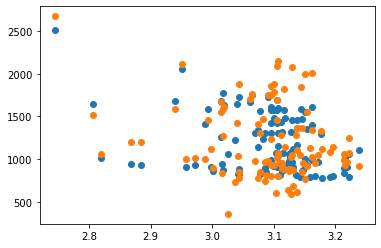

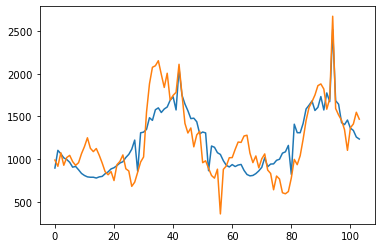

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


Product Wax Oil
Channel Retail - Full Price
loss:  151.41180646745102
nit 1000000
initialization:  1.0
estimated parameters: [ 3.41849581e+00  2.82924096e-01 -1.11030569e-01  8.14594583e-01
  1.40852125e+00  1.42857529e-01  1.72360292e-04  1.00000000e+00]


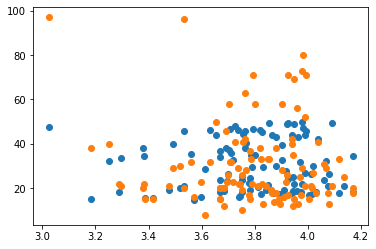

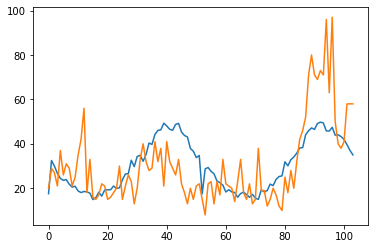

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


loss:  142.48382280562308
nit 887157
initialization:  2.0
estimated parameters: [ 3.35511025 -0.69440983  0.27833327  0.43174277 -0.30838678 -0.1395524
  0.41326461  2.        ]


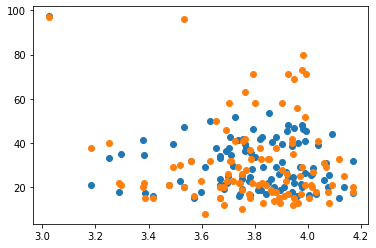

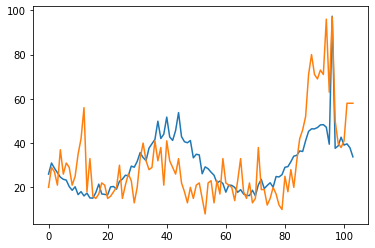

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\linalg.py:100: RuntimeWarning: invalid value encountered in multiply
  return expand(g / ans) * x
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JAELFR~1\AppData\Local\Temp/ipykernel_12448/2856215137.py:36: RuntimeWarning: invalid value encountered in double_scalars
  while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:


In [62]:
#running at 6c
#ALL PRODUCTS LOSS WITH MARKDOWN  
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model8

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(8)
            w_o = i/2*np.ones(8)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




In [63]:
def pnew10(X,w):
    p = w[3]*X[:,2] + w[4]*X[:,3] + w[6]*X[:,0]
    return p

def model10(X,w):
    p_new = pnew10(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = anp.exp(w[0] - beta*(anp.log(p_new)))
    return y

Product Suede And Nubuck Brush
Channel Retail - Full Price
loss:  544.4442239225629
nit 1000000
initialization:  1.0
estimated parameters: [ 4.38486459 -0.05882447  0.02038879 -5.08888301  1.39836356 -0.62539528
  5.88967142  1.        ]


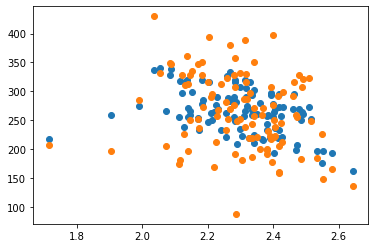

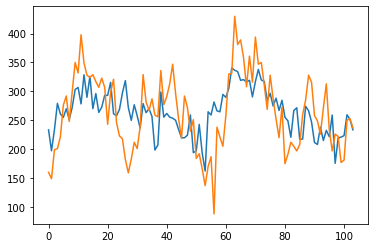

loss:  544.4392874522536
nit 1000000
initialization:  1.5
estimated parameters: [ 4.38531168 -0.05872297  0.02035398 -5.11821748  1.40125517 -0.62406852
  5.91650022  1.5       ]


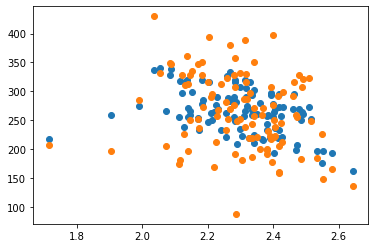

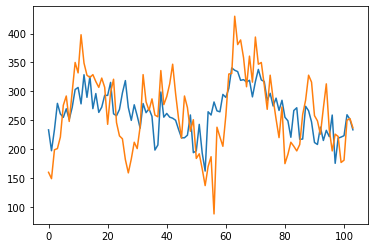

loss:  544.424978233535
nit 1000000
initialization:  2.0
estimated parameters: [ 4.38661254 -0.05842943  0.02025331 -5.20442785  1.40972401 -0.62023148
  5.99528163  2.        ]


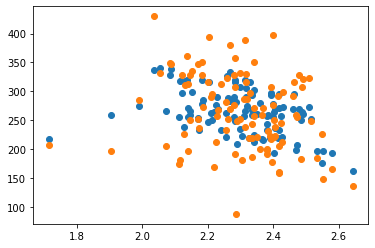

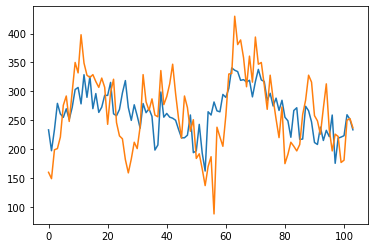

loss:  544.4202743652063
nit 1000000
initialization:  2.5
estimated parameters: [ 4.38704178 -0.05833314  0.02022029 -5.23315727  1.41253684 -0.61897294
  6.02151407  2.5       ]


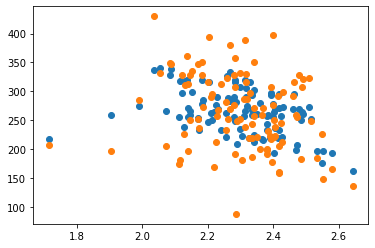

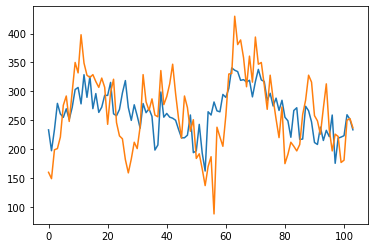

Product Hotter Women's Insoles
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  681.1958768708513
nit 1000000
initialization:  0.5
estimated parameters: [ 5.72952852  1.38590608  1.5817427   0.41936548  1.37030045 -3.27487214
  0.20223882  0.5       ]


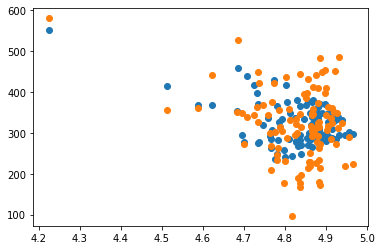

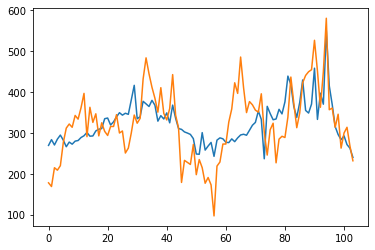

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Product Footwear Cleaner
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  804.9055588804085
nit 1000000
initialization:  0.5
estimated parameters: [ 5.80978848 -1.0363736   0.80197338 -0.56797395 -0.95588018 -4.13771596
  0.40041677  0.5       ]


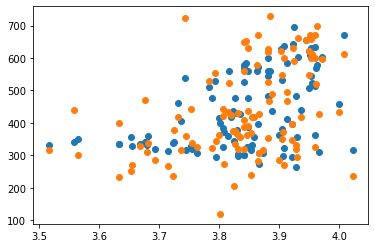

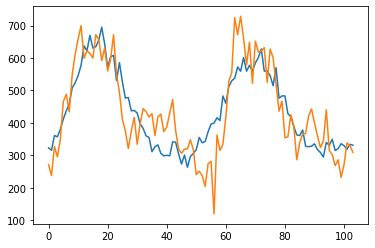

C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


Product Renovating Cream
Channel Retail - Full Price
Product Wax Oil
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


loss:  146.99424656125578
nit 1000000
initialization:  0.5
estimated parameters: [ 3.35255356  4.11387777 -1.58922375  0.24545478  0.495815    1.07752564
  0.26511381  0.5       ]


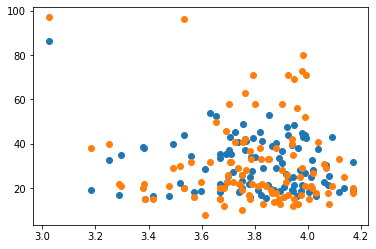

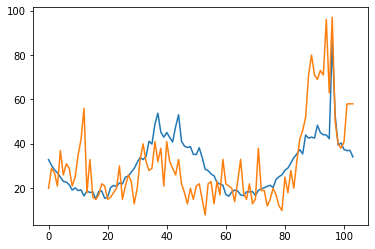

loss:  146.99416283181483
nit 1000000
initialization:  1.0
estimated parameters: [ 3.3525553   4.11569592 -1.58991747  0.24545486  0.49568532  1.07804804
  0.26510207  1.        ]


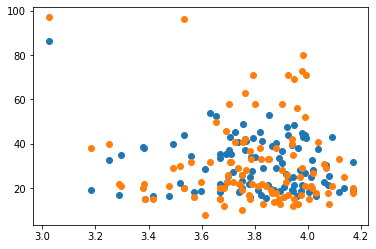

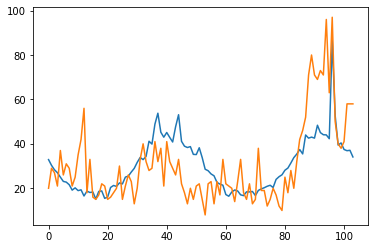

Product Shake
Channel Retail - Full Price
Product Rutland GTX
Channel Retail - Full Price
Product Laurel
Channel Retail - Full Price
Product Leanne
Channel Retail - Full Price
Product Solar
Channel Retail - Full Price
Product Nova
Channel Retail - Full Price
Product Tone
Channel Retail - Full Price


C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
C:\Users\JaelFreixanet\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:78: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.log,   

In [65]:
#running at 6c
#ALL PRODUCTS LOSS WITH MARKDOWN  
z=0
losses = np.zeros((13,14))
real = np.zeros((13,207))
model_used = model10

for prod in products:
    for channel in ['Retail - Full Price']:
        results = np.zeros((14,208))
        
        #We need to aggregate the results so we have a proper time series
        data_prod = data[(data['Description']==prod)&(data['Channel']==channel)]#.groupby(['Date'], as_index=False).agg(aggregations) 
        data_prod = data_prod[['Price','Week_sin','Week_cos','Discount','Markdown','sales']]


        print("Product",prod)
        print("Channel",channel)
        j=0
        loss_old = 5000
        for i in range(-6,6,1):
            X = data_prod.values[:,:-1]
            d = data_prod.values[:,-1]

            w = i/2*np.ones(8)
            w_o = i/2*np.ones(8)
            loss = 10e10
            loss_o = 10e11
            Niterations = 1000000
            eta=0.0001
            nit=0

            start_time = time.time()


            while nit < Niterations and np.abs((loss-loss_o)/loss_o)>1e-15:   
                if loss>loss_o:
                    eta = eta*0.7
                    #print('eta',eta) 
                w_o = w
                loss_o = loss

                gradients = my_training_gradient(d, X, w, model=used_model)
                w -= eta*gradients

                loss = my_autograd_loss(d,X,w,model=used_model)
                #print(nit, loss)

                #if nit % 100000 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                #if nit % 1145394 == 0 : print('nit',nit,' w: ',w, 'grad', gradients, "loss", loss, "time", (time.time() - start_time))
                nit+=1

            losses[z,j] = my_autograd_loss(d,X,w,model=used_model)
            #results[j] = np.array(model5f(X,w))
            if loss< loss_old:
                print('loss: ',loss)
                print("nit",nit)
                print('initialization: ',i/2)
                print('estimated parameters:',w)
                
                plt.scatter(X[:,0],used_model(X,w))
                plt.scatter(X[:,0],d)
                plt.show()

                plt.plot(used_model(X,w))
                plt.plot(d)
                plt.show()
                
                loss_old=loss


            #print("nit",nit)
            j = j+1
        z = z+1




Suede And Nubuck Brush


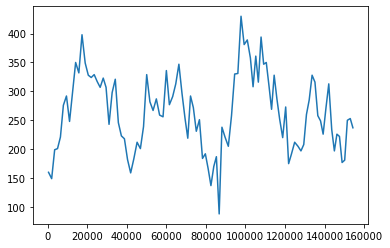

Hotter Women's Insoles


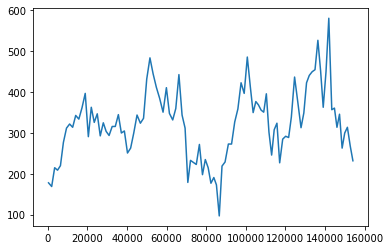

Footwear Cleaner


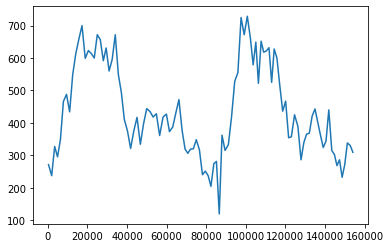

Renovating Cream


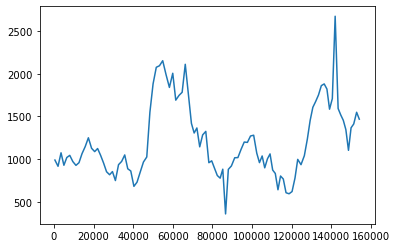

Wax Oil


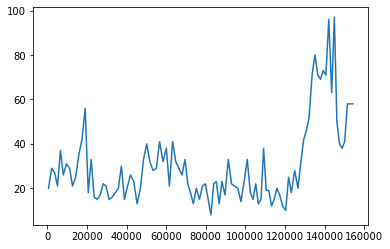

Shake


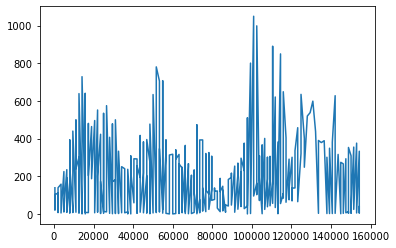

Rutland GTX


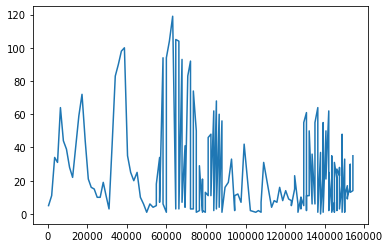

Laurel


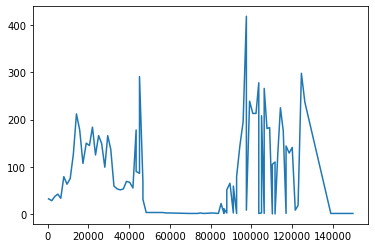

Leanne


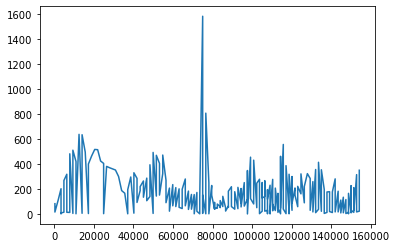

Solar


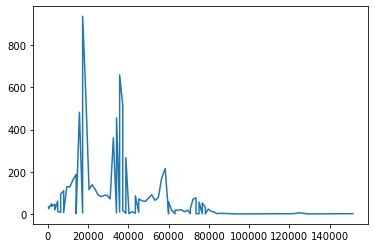

Nova


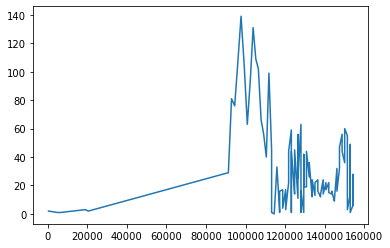

Tone


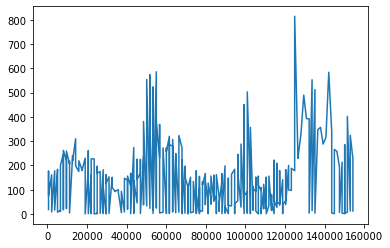

In [81]:
for prod in products:
    print(prod)
    data[(data['Description']==prod)&(data['Channel']=='Retail - Full Price')]['sales'].plot()
    plt.show()

In [85]:
data[(data['Description']=='Footwear Cleaner')&(data['Channel']=='Retail - Full Price')][['Week','Seasonality','Price','Discount','Markdown','Source','sales']]

Week Seasonality     Price  Discount  Markdown   Source  sales
950        1        CONT  3.990331  0.172603  0.003733     NONE  242.0
2508       2        CONT  3.999058  0.167068  0.000541     NONE  191.0
4028       3        CONT  3.896889  0.269500  0.000278     NONE  180.0
5492       4        CONT  3.989115  0.180462 -0.002910     NONE  260.0
6953       5        CONT  3.959674  0.206884  0.000109     NONE  337.0
...      ...         ...       ...       ...       ...      ...    ...
149199    48        CONT  4.072963  0.093333  0.000370  SOURCED   27.0
150509    49        CONT  4.026238  0.140099  0.000330  SOURCED  101.0
151865    50        CONT  3.912152  0.254304  0.000211  SOURCED  158.0
153296    51        CONT  3.994026  0.172208  0.000433  SOURCED   77.0
154627    52        CONT  3.692292  0.473750  0.000625  SOURCED   48.0

[104 rows x 7 columns]

In [93]:
data[(data['WSSI Category']=='Shoe Care')]['Seasonality'].unique()

array(['CONT'], dtype=object)

In [95]:
for cat in data['WSSI Category'].unique():
    print(cat,': ',data[(data['WSSI Category']==cat)]['Seasonality'].unique())

Womens Active Shoes :  ['OLD' 'SS' 'AW' 'CONT']
Womens Formal Shoes :  ['SS' 'CONT' 'OLD' 'AW']
Womens Casual Shoes :  ['SS' 'OLD' 'CONT' 'AW']
Womens Slippers :  ['AW' 'OLD' 'SS' 'CONT']
Mens Casual Shoes :  ['SS' 'OLD' 'AW' 'CONT']
Womens Formal Sandals :  ['SS' 'OLD']
Womens Casual Sandals :  ['SS' 'OLD' 'AW']
Womens Goretex :  ['SS' 'OLD' 'AW' 'CONT']
Womens Deck Shoes :  ['SS' 'AW' 'OLD']
Acc Handbags and Purses :  ['OLD' 'SS' 'AW' 'CONT']
Mens Formal Shoes :  ['SS' 'OLD' 'CONT' 'AW']
Womens Casual Boots :  ['AW' 'OLD' 'SS']
Mens Slippers :  ['CONT' 'SS' 'OLD' 'AW']
Womens Smart Casual Shoes :  ['OLD' 'SS' 'CONT' 'AW']
 NO CATEGORY :  [' NO SEASONALITY']
Womens Formal Boots :  ['OLD' 'AW' 'SS']
Shoe Care :  ['CONT']
Other Accessories :  ['CONT' 'OLD' 'SS' 'AW']
Mens Sandals :  ['OLD' 'SS']
Free Gift :  [' NO SEASONALITY']
Mens Goretex :  ['OLD' 'CONT' 'SS' 'AW']
Mens Boots :  ['OLD' 'AW']
